# Raster data

## Some basic principles

> a raster graphic represents a two-dimensional picture as a rectangular matrix or grid of ~square pixels~
<div>
<img src="images/simple_raster.png" width="500"/>
</div>

source: [wikipedia](https://en.wikipedia.org/wiki/Raster_graphics#Image_storage)


In [1]:
import matplotlib.pyplot as plt
import numpy as np

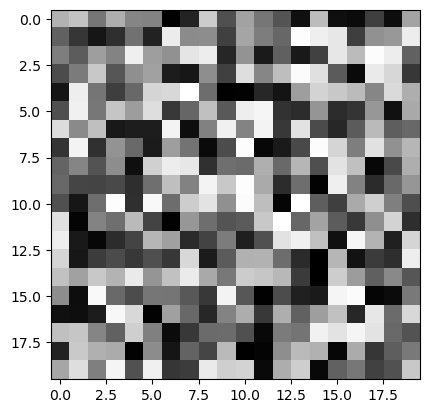

In [2]:
raster = np.random.rand(20, 20)
plt.imshow(raster, cmap="gray")

A simplistic representation of an image is just an array of shape `x, y, 3` where the last axis represents the red, green and blue chanels.

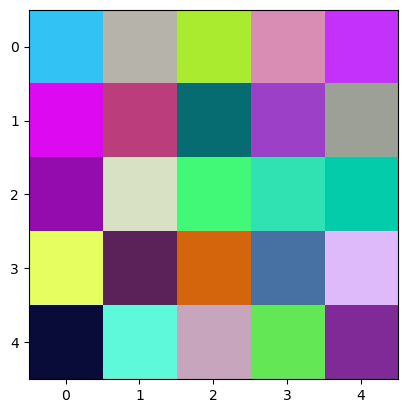

In [67]:
image = np.random.rand(5, 5, 3)
plt.imshow(image)

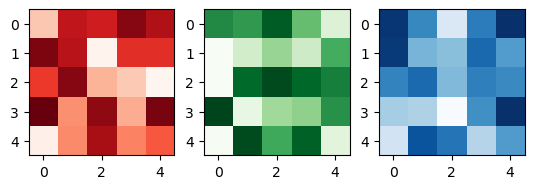

In [68]:
_, axs = plt.subplots(1, 3)
axs[0].imshow(image[:, :, 0], cmap="Reds")
axs[1].imshow(image[:, :, 1], cmap="Greens")
axs[2].imshow(image[:, :, 2], cmap="Blues")

In [5]:
plt.imsave("example.png", image)

## But...  maps?

Rasters can be _georeferenced_ to represent data on earth surface. 

In order to make it work we need to know
- where the raster is on earth
- the size of the pixels
- which reference system we are using: the Coordinate Reference System (CRS)

All this adds new metadata to our simple image format.

Here is where we will take advantage of libraries like [Rasterio](https://rasterio.readthedocs.io/en/latest/index.html).

Let's try to convert our image to fully privileged geospatial raster

In [83]:
import rasterio as rio
from rasterio.transform import Affine
from rasterio.plot import reshape_as_raster, reshape_as_image

# we are going to use a lat long projection so units must be in degrees
crs = "+proj=latlong"
# crs can also be defined using the espg code
crs = "epsg:4326"

# note it is negative! we are defining things from the upper left corner.
xres, yres = 0.005, -0.005

transform = Affine.translation(2.944591, 39.445561) * Affine.scale(xres, yres)

with rio.open(
    "raster.tiff",
    mode="w",
    height=image.shape[0],
    width=image.shape[1],
    count=3,  # number of band
    dtype=image.dtype,
    crs=crs,
    transform=transform,
) as new_raster:

    # rasterio wants the axis in the order bands, cols, rows.
    new_raster.write(reshape_as_raster(image))

\- wowowo hold your horses, what is this affine, why multiply !?

\- It is just a way to define the upper left origin of our raster and the pixel size! it's super simple, you just needs to use a little bit of **linear algebra**

\* _leaves_


In [70]:
print(transform)

| 0.01, 0.00, 2.94|
| 0.00,-0.01, 39.45|
| 0.00, 0.00, 1.00|


\* Disclaimer: Sorry to all the people who knows linear algebra. I'm trying to do my best and be short

The `transform` variable is an `Affine`  object that represents an affine transformation like:


$$
\begin{vmatrix}
    x' \\
    y' \\
    1
\end{vmatrix}
= 
\begin{vmatrix}
    a & b & c \\
    d & e & f \\
    0 & 0 & 1
\end{vmatrix}
\ 
\begin{vmatrix}
    x \\
    y \\
    1
\end{vmatrix}
$$

Here with the matrix $\begin{vmatrix} a & b & c \\ d & e & f \\ 0 & 0 & 1\end{vmatrix}$ we transform the image coordinates $x, y$ to world coordinates $x', y'$

It is quite interesnting how this works but we don't have time. Look into [this](https://pygis.io/docs/d_affine.html) for a slightly deeper explaination or this [videos](https://www.youtube.com/watch?v=fNk_zzaMoSs&list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab) if you want to get a full intuition on what is going on.

In our application most of the time we will only need `translate` (move the points) and to `scale`

so in the line 
```python
transform = Affine.translation(2.944591, 39.445561) * Affine.scale(xres, yres)
```
we are saying that our 0,0 pixel (in image coordinates, upper left corner) is at  39.445561°N 2.944591°E and the pixels measure 0.005° each side.

_**NOTE** that the units are in degrees because we are using a coordinate reference system that is in degrees!_

So the interesnting bits of our transform matrix are:

$$
\begin{vmatrix}
    x_{size} & \cdot & x_0 \\
    \cdot & y_{size} & y_0 \\
    \cdot & \cdot & \cdot
\end{vmatrix}
$$

this is why the affine object looks like:

```
| 0.005,     0,  2.94|
|     0,-0.005, 39.45|
|     0,     0,     1|
```

In [8]:
np.asarray(Affine.translation(10, 10) * Affine.scale(1, -1)).reshape(3,3) @ [1, 1, 1]

array([11.,  9.,  1.])

## Reprojecting

Now let's reproject a raster from one CRS to another.

But first let's display it..

In [71]:
with rio.open("images/cabrera_rgba.tif") as src:
    img = src.read()
    img_crs = src.crs
    img_extent = rio.plot.plotting_extent(src)
    print(src.transform)


| 10.00, 0.00, 488465.00|
| 0.00,-10.00, 4342275.00|
| 0.00, 0.00, 1.00|


In [74]:
print(img_extent)
print(img_crs)

(488465.0, 502905.0, 4328375.0, 4342275.0)
EPSG:32631


In [76]:
img.shape

(4, 1390, 1444)

In [81]:
reshape_as_image(img).shape

(1390, 1444, 4)

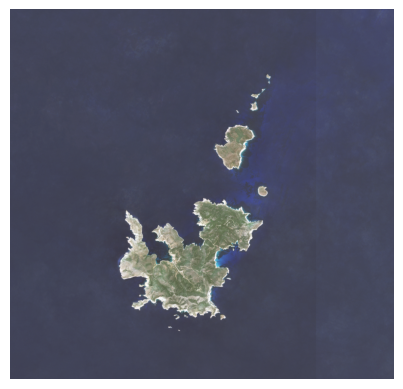

In [85]:
plt.imshow(reshape_as_image(img))
plt.gca().set_axis_off()

The crs EPSG:32631 is the UTM zone 31, so if we want to display it we should use a map with the same crs or reproject the raster if we want another one.

For making simple maps we are going to use matplotlib + [Cartopy](https://github.com/SciTools/cartopy)

In [86]:
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Cartopy "patches" matplotlib and allow us to define a projection to the axis

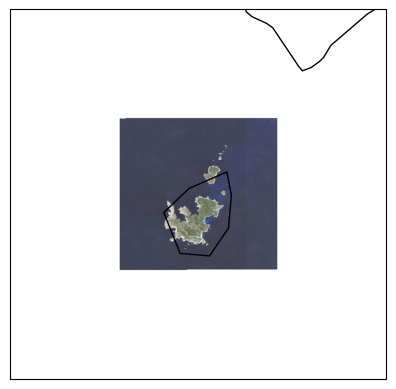

In [87]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.Mercator())

x0, x1, y0, y1 = img_extent
room = 10_000
plot_extent = x0 - room, x1 + room, y0 - room, y1 + room 
ax.set_extent(plot_extent, crs=ccrs.UTM("31"))

ax.imshow(reshape_as_image(img), transform=ccrs.UTM("31"), extent=img_extent)
ax.add_feature(cartopy.feature.COASTLINE)


_NOTE the coastline resolution is too low for this zoom level. We will fix this in a while._

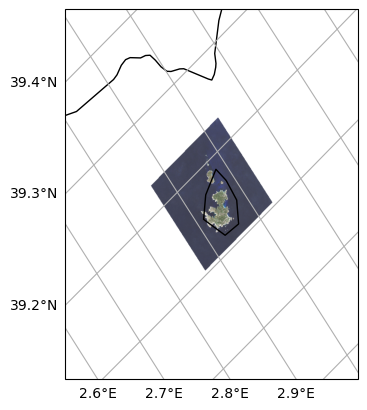

In [90]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=-50, central_latitude=50))

x0, x1, y0, y1 = img_extent
room = 10_000
plot_extent = x0 - room, x1 + room, y0 - room, y1 + room 
ax.set_extent(plot_extent, crs=ccrs.UTM("31"))

gl = ax.gridlines(draw_labels=True) 
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.imshow(reshape_as_image(img), transform=ccrs.UTM("31"), extent=img_extent)
ax.add_feature(cartopy.feature.COASTLINE)

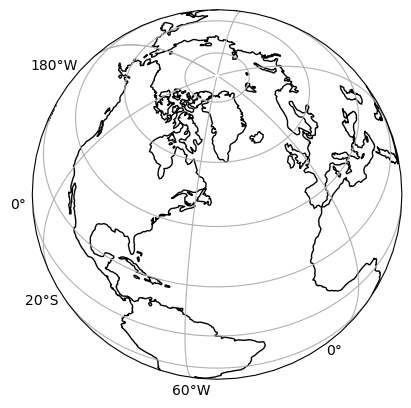

In [50]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=-50, central_latitude=50))
ax.coastlines()

gl = ax.gridlines(draw_labels=True) 
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

### Changing CRS of the data

For now we have only been changing the projection on the fly for the map.


What if we want to do some analysis or store the data in another CRS abd make it persistent?

In [64]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:4326'  # geographical coordinate system that uses lat/long and degrees

with rio.open('images/cabrera_rgba.tif') as src:
    
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds, resolution=0.001)
    
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rio.open('images/cabrera_rgba_reproj.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [91]:
with rio.open("images/cabrera_rgba_reproj.tif") as src:
    print(src.crs)
transform

EPSG:4326


Affine(0.005, 0.0, 2.944591,
       0.0, -0.005, 39.445561)

Most of the magic hapens in `calculate_default_transform` where we calculate the new Affine matrix for the destination crs.

Then `reproject` deals with witring the new data with the correct metadata.

## Xarray + Rasterio!

In [94]:
import rioxarray

In [98]:
raster = rioxarray.open_rasterio("images/cabrera_rgba.tif")

In [99]:
raster

<xarray.DataArray (band: 4, y: 1390, x: 1444)>
[8028640 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 4.885e+05 4.885e+05 ... 5.029e+05 5.029e+05
  * y            (y) float64 4.342e+06 4.342e+06 ... 4.328e+06 4.328e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    resolution:     10
    spec:           RasterSpec(epsg=32631, bounds=(488470, 4328370, 502910, 4...
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      true_color

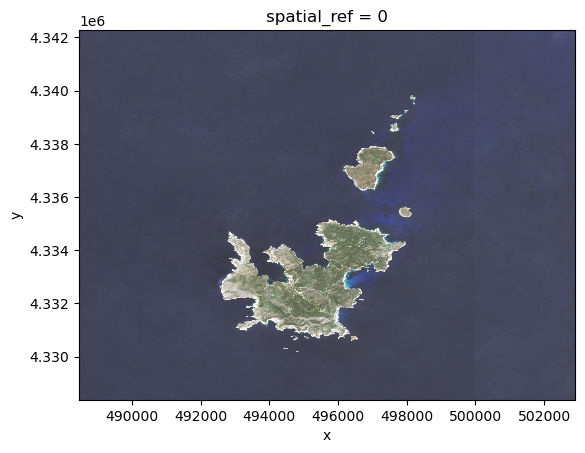

In [129]:
raster.plot.imshow()

In [101]:
import geopandas as gpd

In [105]:
coast = gpd.read_file("vector/costa_balears.geojson")
coast.head()

,geometry
0,"POLYGON ((2.93860 39.12596, 2.93832 39.12585, ..."
1,"POLYGON ((2.97266 39.19535, 2.97242 39.19532, ..."
2,"POLYGON ((2.94045 39.12077, 2.94039 39.12073, ..."
3,"POLYGON ((2.96385 39.14789, 2.96377 39.14783, ..."
4,"POLYGON ((2.97842 39.20650, 2.97829 39.20648, ..."


epsg:4326


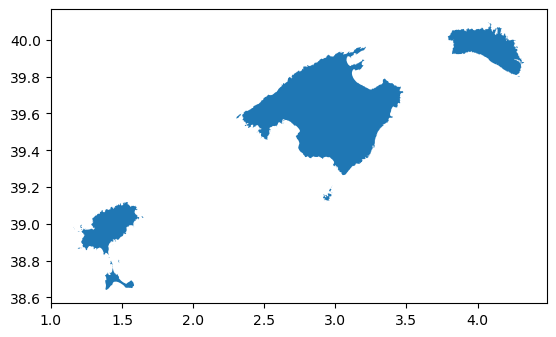

In [108]:
coast.plot()
print(coast.crs)

Let's remove the sea by clipping it out with the help of the coastline polygon (and rioxarray).

In [278]:
clipped = raster.rio.clip(coast.geometry.to_list(), crs=coast.crs)

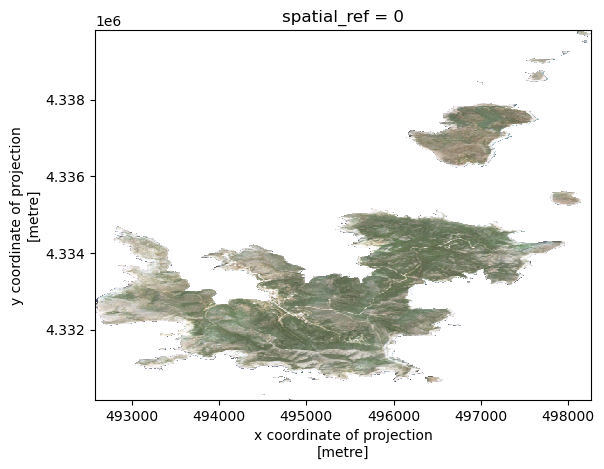

In [279]:
clipped.plot.imshow()

How about adding it to an interactive map!?

First of all we will need to convert it to world mercator (interactive maps are in world mercator):

In [291]:
clipped = clipped.rio.reproject("epsg:4316")

In [292]:
clipped.rio.bounds()

(2.914116796226584, 39.12073834650767, 2.9799461752496583, 39.207601964981905)

In [293]:
clipped.rio.crs

CRS.from_epsg(4316)

In [294]:
import folium
from utils import convert_bounds


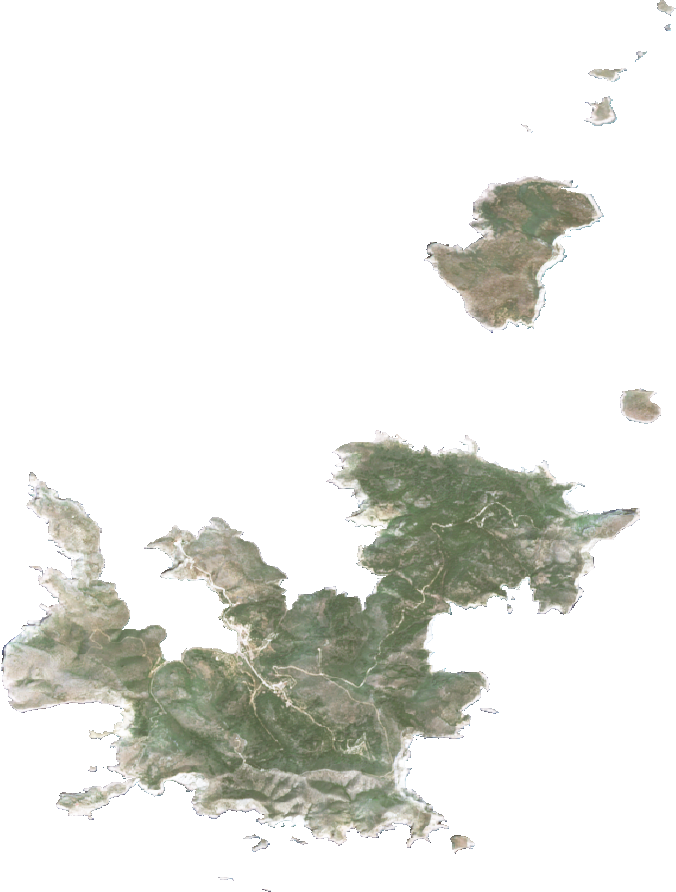

In [306]:
m = folium.Map([39.1, 2.97], zoom_start=11)
folium.raster_layers.ImageOverlay(
    image=reshape_as_image(clipped.values),
    bounds=convert_bounds(clipped.rio.bounds()),
    zindex=1
).add_to(m)

folium.LayerControl().add_to(m)
m